# UDA Final Project

Yanran Xu (CID:02351471)

# Import

In [2]:
import os
import sys
from IPython.display import HTML, display

import numpy as np
import pandas as pd
import tensorflow as tf
from math import ceil
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import random
import time
import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preparation

In [4]:
# Load data
SUMMARY_PATH = '/content/drive/MyDrive/UDA_Final/MutualFundSummary'
SUMMARY_LABELS_PATH = '/content/drive/MyDrive/UDA_Final/MutualFundLabels.csv'

In [5]:
# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Save a word2vec dictionary.
def save_word2vec(filename):
    with open(os.path.join('/content/drive/MyDrive/UDA_Final', filename),'a' , encoding="latin-1") as f : #utf-8
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    with open(os.path.join('/content/drive/MyDrive/UDA_Final', filename), encoding="latin-1") as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="latin-1") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        texts.append(summary)
        fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

glove_word2vec = 'glove.6B.50d.txt'
#our_word2vec = 'word2vec_perso.txt'

In [109]:
# Get the summaries
fund_names, summaries = get_data(SUMMARY_PATH)

In [110]:
df_label = pd.read_csv(SUMMARY_LABELS_PATH)
df_label.columns = df_label.columns.str.replace('Ivestment Strategy', 'Investment_Strategy')
df_label.columns = df_label.columns.str.replace('Performance fee?', 'Performance fee', regex=False)
df_label.columns = df_label.columns.str.replace('Leverage?', 'Leverage', regex=False)

df_label.head()

,id,fund_name,Performance fee,Investment_Strategy,Leverage,Portfolio composition,Concentration
0,0000051931-18-000151,American Funds College 2018 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
1,0000051931-18-000151,American Funds College 2021 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
2,0000051931-18-000151,American Funds College 2024 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
3,0000051931-18-000151,American Funds College 2027 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
4,0000051931-18-000151,American Funds College 2030 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified


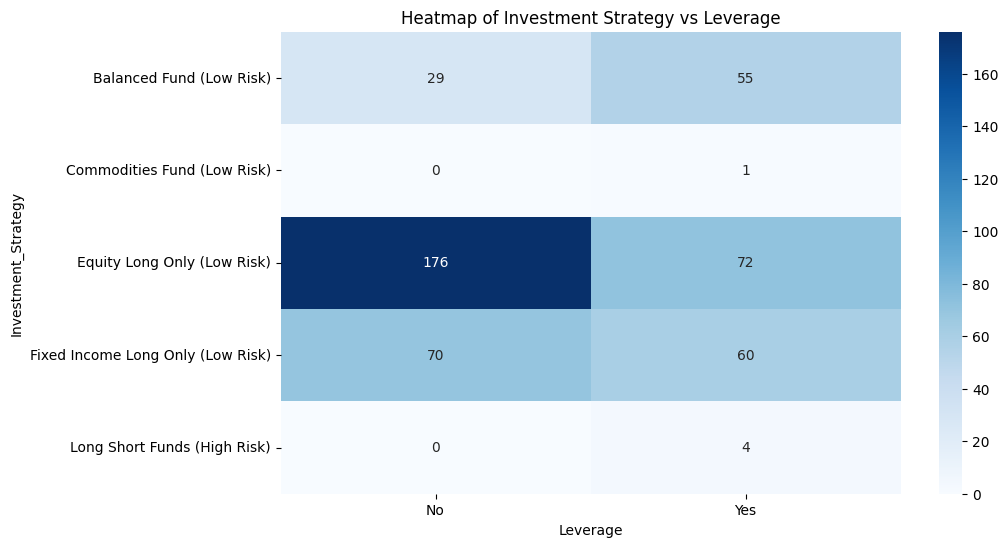

In [8]:
# heatmap
cross_tab = pd.crosstab(df_label['Investment_Strategy'],df_label['Leverage'])

plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='g')
plt.title('Heatmap of Investment Strategy vs Leverage')
plt.show()

In [9]:
# Count the occurrences of each label in the dataset
label_counts = df_label['Investment_Strategy'].value_counts()
label_counts

,count
Investment_Strategy,
Equity Long Only (Low Risk),248
Fixed Income Long Only (Low Risk),130
Balanced Fund (Low Risk),84
Long Short Funds (High Risk),4
Commodities Fund (Low Risk),1


There are 4 main types: “Balanced Fund (Low Risk)”, “Fixed Income
Long Only (Low Risk)”, “Equity Long Only (Low Risk)”, and Long Short Funds (High Risk),
excluding one other type with only one fund.

In [111]:
desired_labels = ['Balanced Fund (Low Risk)', 'Fixed Income Long Only (Low Risk)', 'Equity Long Only (Low Risk)', 'Long Short Funds (High Risk)']
df_label = df_label[df_label['Investment_Strategy'].isin(desired_labels)]
label_counts = df_label['Investment_Strategy'].value_counts()
label_counts

,count
Investment_Strategy,
Equity Long Only (Low Risk),248
Fixed Income Long Only (Low Risk),130
Balanced Fund (Low Risk),84
Long Short Funds (High Risk),4


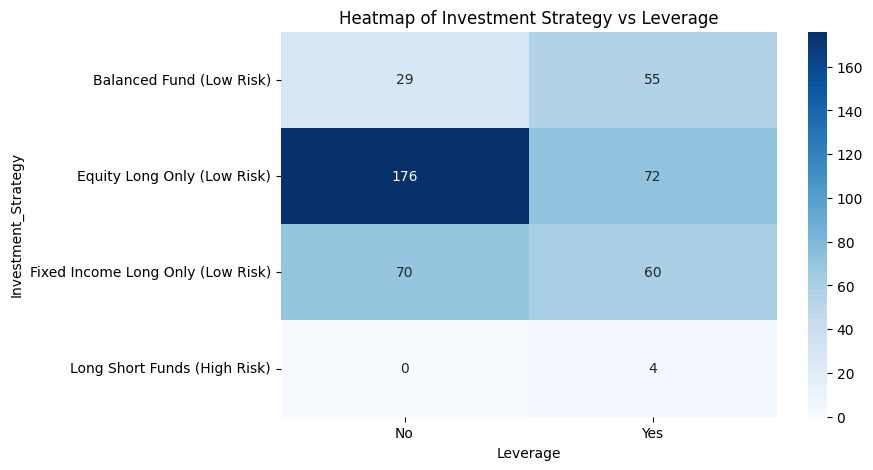

In [11]:
# heatmap
cross_tab = pd.crosstab(df_label['Investment_Strategy'],df_label['Leverage'])

plt.figure(figsize=(8, 5))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='g')
plt.title('Heatmap of Investment Strategy vs Leverage')
plt.show()

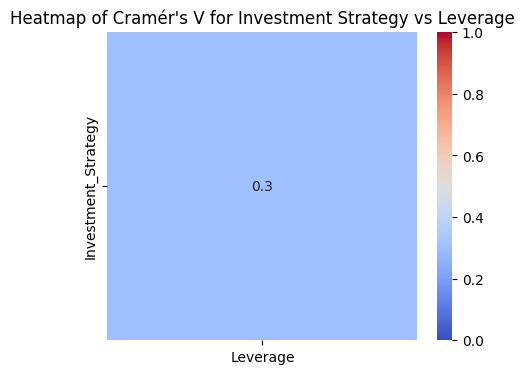

In [12]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    chi2, _, _, _ = chi2_contingency(pd.crosstab(x, y))
    n = len(x)
    min_dim = min(pd.crosstab(x, y).shape) - 1
    return (chi2 / n / min_dim) ** 0.5

# Cramér's V
cramer_v_value = cramers_v(df_label['Investment_Strategy'], df_label['Leverage'])
cramer_v_matrix = pd.DataFrame([[cramer_v_value]], index=["Investment_Strategy"], columns=["Leverage"])

# heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cramer_v_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Heatmap of Cramér's V for Investment Strategy vs Leverage")
plt.show()


In [13]:
# leverage_ratios
leverage_ratios = pd.crosstab(df_label['Investment_Strategy'], df_label['Leverage'], normalize='index')

conditional_probabilities = leverage_ratios.copy()
conditional_probabilities['Leverage Probability (Yes)'] = leverage_ratios['Yes']
conditional_probabilities = conditional_probabilities[['Leverage Probability (Yes)']]

leverage_ratios, conditional_probabilities


(Leverage                                 No       Yes
 Investment_Strategy                                  
 Balanced Fund (Low Risk)           0.345238  0.654762
 Equity Long Only (Low Risk)        0.709677  0.290323
 Fixed Income Long Only (Low Risk)  0.538462  0.461538
 Long Short Funds (High Risk)       0.000000  1.000000,
 Leverage                           Leverage Probability (Yes)
 Investment_Strategy                                          
 Balanced Fund (Low Risk)                             0.654762
 Equity Long Only (Low Risk)                          0.290323
 Fixed Income Long Only (Low Risk)                    0.461538
 Long Short Funds (High Risk)                         1.000000)

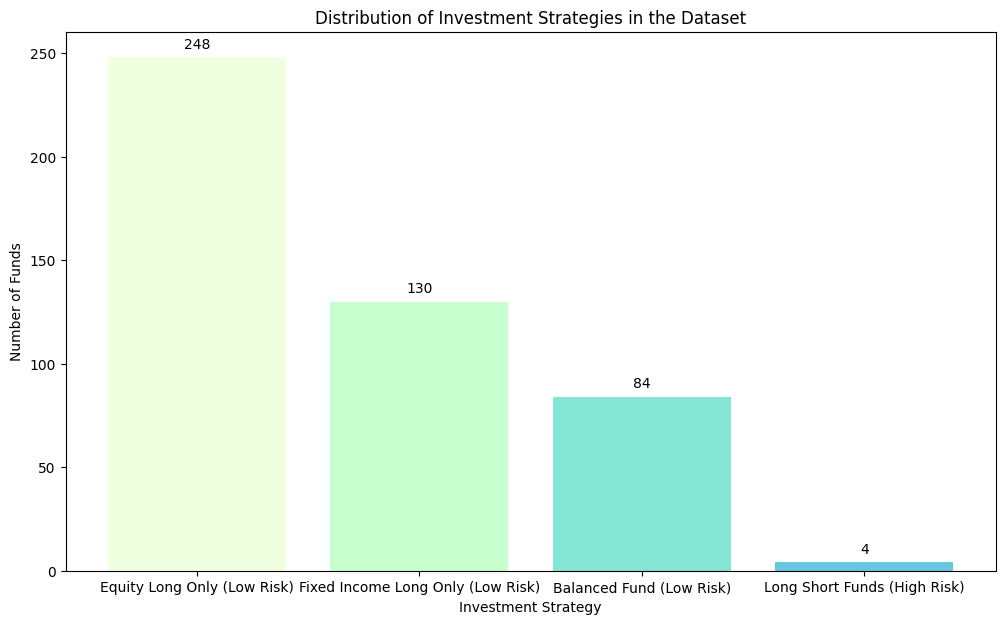

In [14]:
import matplotlib.pyplot as plt
# Create a bar chart to visualize the distribution of labels
plt.figure(figsize=(12, 7))
colors = ['#EFFFE0', '#C7FFCE', '#85E6D5', '#68C6E3']  # specify colors for each bar
bars = plt.bar(label_counts.index, label_counts.values, color = colors)
# Adding the text labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 3, yval, ha='center', va='bottom')

plt.xlabel('Investment Strategy')
plt.ylabel('Number of Funds')
plt.title('Distribution of Investment Strategies in the Dataset')
plt.show()


In [112]:
# Transfer the variable 'Investmet_Strategy' into a categorical variable
df_label['Investment_Strategy'].replace(['Balanced Fund (Low Risk)', 'Fixed Income Long Only (Low Risk)', 'Equity Long Only (Low Risk)', 'Long Short Funds (High Risk)'],
                        [0, 1, 2, 3], inplace=True)

<ipython-input-112-bd1eabc33f63>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_label['Investment_Strategy'].replace(['Balanced Fund (Low Risk)', 'Fixed Income Long Only (Low Risk)', 'Equity Long Only (Low Risk)', 'Long Short Funds (High Risk)'],
<ipython-input-112-bd1eabc33f63>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future

In [113]:
# there are only four “Long Short Funds (High Risk)” funds in the data set.
# select them and then put 2 of them in training set and the rest 2 in testing set
minor_funds = df_label.loc[df_label['Investment_Strategy']== 3]
print(minor_funds['fund_name'])

301               Columbia Mortgage Opportunities Fund
423             Anchor Tactical Equity Strategies Fund
424          Anchor Tactical Municipal Strategies Fund
425    Dreyfus Alternative Diversifier Strategies Fund
Name: fund_name, dtype: object


In [114]:
minor_fund_names = minor_funds['fund_name']

In [115]:
minor_idx = [fund_names.index(fund) for fund in fund_names if fund in list(minor_fund_names)]
minor_idx

[79, 84, 113, 148]

In [20]:
minor_fund_summaries = [summary for summary in summaries if summaries.index(summary) in minor_idx]

In [21]:
df_minor = pd.DataFrame(data={'fund_name':minor_fund_names, 'summary':minor_fund_summaries})
# Whole dataset except for the fourth category, which will be classified using the minor detection
minor_funds = df_minor.merge(minor_funds, on =['fund_name'], how ='left')
minor_funds

,fund_name,summary,id,Performance fee,Investment_Strategy,Leverage,Portfolio composition,Concentration
0,Columbia Mortgage Opportunities Fund,FUND SUMMARY - ANCHOR TACTICAL EQUITY STRATEGI...,0001193125-18-285341,NaN,3,Yes,Investment grade securities,Concentrated by issuer / sector / jurisdiction
1,Anchor Tactical Equity Strategies Fund,FUND SUMMARY - ANCHOR TACTICAL MUNICIPAL STRAT...,0001580642-18-006021,NaN,3,Yes,Investment grade securities,Diversified
2,Anchor Tactical Municipal Strategies Fund,SUMMARY OF THE FUND\nInvestment Objective\nCol...,0001580642-18-006021,NaN,3,Yes,Investment grade securities,Diversified
3,Dreyfus Alternative Diversifier Strategies Fund,Fund Summary\n\nInvestment Objective\nThe fund...,0001591556-18-000016,NaN,3,Yes,Sub-investment grade securities or emerging ma...,Diversified


In [22]:
# choose funds that are not outlier funds
major_fund_names = [fund for fund in fund_names if fund not in list(minor_fund_names)]
major_fund_summaries = [summary for summary in summaries if summaries.index(summary) not in minor_idx]
print(len(major_fund_names),len(major_fund_summaries))

541 541


In [23]:
df_major = pd.DataFrame(data={'fund_name':major_fund_names, 'summary':major_fund_summaries})
# Whole dataset except for the fourth category, which will be classified using the minor detection
df_merge = df_major.merge(df_label, on =['fund_name'], how ='left')
df_merge.dropna(subset=['Investment_Strategy'], inplace=True)
df_merge

,fund_name,summary,id,Performance fee,Investment_Strategy,Leverage,Portfolio composition,Concentration
28,ADAPTIVE EQUITY FUND,Fund Summary \nInvestment Objective\nThe fund ...,0000100334-18-000027,NaN,2.0,No,Listed Equities,Diversified
32,AllianzGI Emerging Markets Opportunities Fund,Investment Objective\n\nThe Fund seeks maximum...,0001193125-18-209592,NaN,2.0,Yes,Sub-investment grade securities or emerging ma...,Diversified
33,Aggressive Growth Fund,INVESTMENT OBJECTIVE\nThe USAA Aggressive Grow...,0001683863-18-000443,Some performance Fees,2.0,No,Listed Equities,Diversified
34,ALL CAP GROWTH FUND,Fund Summary\nInvestment Objective\nThe fund s...,0000100334-18-000027,NaN,2.0,No,Listed Equities,Diversified
35,AllianzGI Health Sciences Fund,Investment Objective\n\nThe Fund seeks long-te...,0001193125-18-209592,NaN,2.0,Yes,Listed Equities,Concentrated by issuer / sector / jurisdiction
...,...,...,...,...,...,...,...,...
536,Variable Portfolio - Victory Sycamore Establis...,SUMMARY OF CTIVPSM â VICTORY SYCAMORE ESTABL...,0001193125-18-139001,NaN,2.0,No,Listed Equities,Diversified
537,Variable Portfolio - TCW Core Plus Bond Fund,SUMMARY OF CTIVPSM â TCW CORE PLUS BOND FUND...,0001193125-18-139001,NaN,1.0,Yes,Investment grade securities,Diversified
538,Western Asset Intermediate Maturity New York M...,Investment objective\n\nThe fund seeks to prov...,0001193125-18-091654,NaN,1.0,Yes,Investment grade securities,Concentrated by issuer / sector / jurisdiction
539,Western Asset Massachusetts Municipals Fund,Investment objective\n\nThe fund seeks to prov...,0001193125-18-091654,NaN,1.0,Yes,Investment grade securities,Concentrated by issuer / sector / jurisdiction


# Text Cluster

In [116]:
df_all = pd.DataFrame(data={'fund_name':fund_names, 'summary':summaries})
# Whole dataset except for the fourth category, which will be classified using the minor detection
df_all = df_all.merge(df_label, on =['fund_name'], how ='left')
df_all.dropna(subset=['Investment_Strategy'], inplace=True)
df_all

,fund_name,summary,id,Performance fee,Investment_Strategy,Leverage,Portfolio composition,Concentration
28,ADAPTIVE EQUITY FUND,Fund Summary \nInvestment Objective\nThe fund ...,0000100334-18-000027,NaN,2.0,No,Listed Equities,Diversified
32,AllianzGI Emerging Markets Opportunities Fund,Investment Objective\n\nThe Fund seeks maximum...,0001193125-18-209592,NaN,2.0,Yes,Sub-investment grade securities or emerging ma...,Diversified
33,Aggressive Growth Fund,INVESTMENT OBJECTIVE\nThe USAA Aggressive Grow...,0001683863-18-000443,Some performance Fees,2.0,No,Listed Equities,Diversified
34,ALL CAP GROWTH FUND,Fund Summary\nInvestment Objective\nThe fund s...,0000100334-18-000027,NaN,2.0,No,Listed Equities,Diversified
35,AllianzGI Health Sciences Fund,Investment Objective\n\nThe Fund seeks long-te...,0001193125-18-209592,NaN,2.0,Yes,Listed Equities,Concentrated by issuer / sector / jurisdiction
...,...,...,...,...,...,...,...,...
540,Variable Portfolio - Victory Sycamore Establis...,SUMMARY OF CTIVPSM â VICTORY SYCAMORE ESTABL...,0001193125-18-139001,NaN,2.0,No,Listed Equities,Diversified
541,Variable Portfolio - TCW Core Plus Bond Fund,SUMMARY OF CTIVPSM â TCW CORE PLUS BOND FUND...,0001193125-18-139001,NaN,1.0,Yes,Investment grade securities,Diversified
542,Western Asset Intermediate Maturity New York M...,Investment objective\n\nThe fund seeks to prov...,0001193125-18-091654,NaN,1.0,Yes,Investment grade securities,Concentrated by issuer / sector / jurisdiction
543,Western Asset Massachusetts Municipals Fund,Investment objective\n\nThe fund seeks to prov...,0001193125-18-091654,NaN,1.0,Yes,Investment grade securities,Concentrated by issuer / sector / jurisdiction


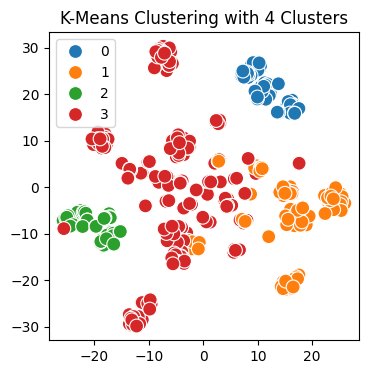

In [148]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_all['summary'])

# Apply K-Means clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(tfidf_matrix)

# Add cluster labels to the selected DataFrame
df_all['Cluster_K'] = cluster_labels

# Visualize clusters with t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(4, 4))
sns.scatterplot(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    hue=cluster_labels,
    palette='tab10',
    s=100
)
plt.title("K-Means Clustering with 4 Clusters")
plt.show()

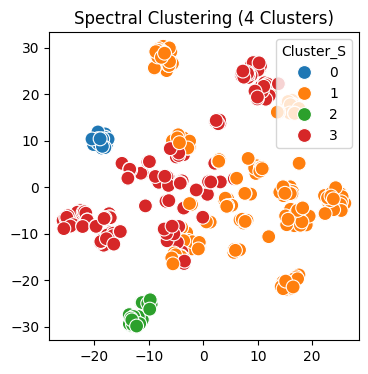

In [149]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity

# Compute similarity matrix
similarity_matrix = cosine_similarity(tfidf_matrix)

# Apply Spectral Clustering with 4 clusters
spectral = SpectralClustering(n_clusters=4, affinity='precomputed', random_state=42)
cluster_labels = spectral.fit_predict(similarity_matrix)

# Add cluster labels back to the DataFrame
df_all['Cluster_S'] = cluster_labels

# Visualize as before using t-SNE
plt.figure(figsize=(4, 4))
sns.scatterplot(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    hue=df_all['Cluster_S'],
    palette='tab10',
    s=100
)
plt.title("Spectral Clustering (4 Clusters)")
plt.show()

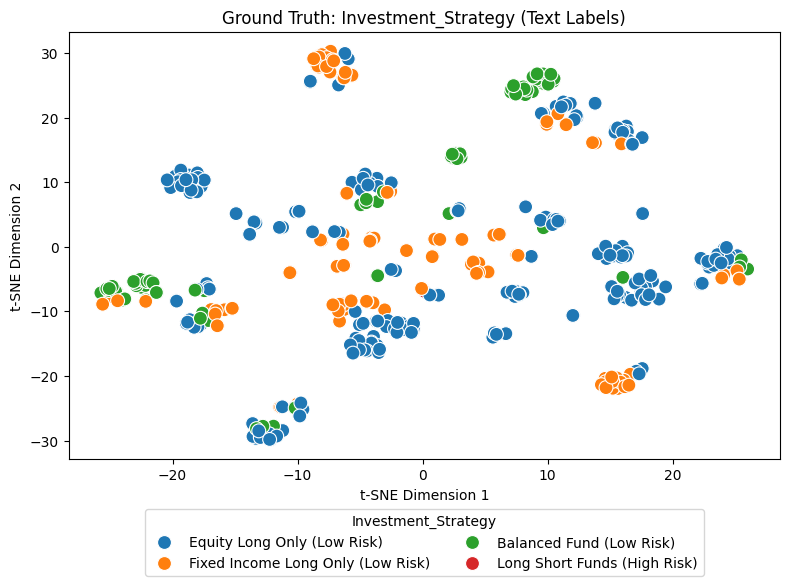

In [146]:
# Visualize the actual Investment_Strategy categories
# Define the mapping dictionary
strategy_mapping = {
    0: 'Balanced Fund (Low Risk)',
    1: 'Fixed Income Long Only (Low Risk)',
    2: 'Equity Long Only (Low Risk)',
    3: 'Long Short Funds (High Risk)'
}

# Map the numeric values back to text
df_all['Investment_Strategy_Text'] = df_all['Investment_Strategy'].map(strategy_mapping)

# Plot the ground truth using text labels
plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    hue=df_all['Investment_Strategy_Text'],  # Use text labels
    palette='tab10',
    s=100
)
plt.title("Ground Truth: Investment_Strategy (Text Labels)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Move the legend below the plot
plt.legend(
    title="Investment_Strategy",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1),  # Position the legend below
    ncol=2  # Arrange legend items in two columns
)

plt.tight_layout()
plt.show()


In [150]:
from sklearn.metrics import homogeneity_score, completeness_score, adjusted_rand_score

# Ground truth labels
true_labels = df_all['Investment_Strategy']

# K-Means clustering labels
kmeans_labels = df_all['Cluster_K']

# Spectral clustering labels (replace this with your spectral clustering results)
spectral_labels = df_all['Cluster_S']

# Compute metrics for K-Means
kmeans_homogeneity = homogeneity_score(true_labels, kmeans_labels)
kmeans_completeness = completeness_score(true_labels, kmeans_labels)
kmeans_ari = adjusted_rand_score(true_labels, kmeans_labels)

# Compute metrics for Spectral Clustering
spectral_homogeneity = homogeneity_score(true_labels, spectral_labels)
spectral_completeness = completeness_score(true_labels, spectral_labels)
spectral_ari = adjusted_rand_score(true_labels, spectral_labels)

# Print results
print("K-Means Clustering Metrics:")
print(f"  Homogeneity: {kmeans_homogeneity:.4f}")
print(f"  Completeness: {kmeans_completeness:.4f}")
print(f"  Adjusted Rand Index (ARI): {kmeans_ari:.4f}")

print("\nSpectral Clustering Metrics:")
print(f"  Homogeneity: {spectral_homogeneity:.4f}")
print(f"  Completeness: {spectral_completeness:.4f}")
print(f"  Adjusted Rand Index (ARI): {spectral_ari:.4f}")


K-Means Clustering Metrics:
  Homogeneity: 0.1055
  Completeness: 0.0903
  Adjusted Rand Index (ARI): 0.0678

Spectral Clustering Metrics:
  Homogeneity: 0.1422
  Completeness: 0.1460
  Adjusted Rand Index (ARI): 0.0988


Based on these metrics, Spectral Clustering is the better method for the dataset. While both methods yield relatively low scores, indicating room for improvement in the clustering process, Spectral Clustering aligns better with the ground truth labels (Investment_Strategy).

After clustering, we move to text classification because clustering provides groupings without predefined labels, while classification allows us to predict specific categories (Investment_Strategy) based on labeled data. This makes classification more actionable for tasks like automated labeling and decision-making.

# Text Classification

## Step 1: Split data into train validation and test





In [35]:
# Split the feature and the target
major_X = df_merge[df_merge.columns.drop('Investment_Strategy')]
major_y = df_merge['Investment_Strategy']
major_X.shape

(461, 7)

In [36]:
# Split the data into training and testing sets
major_X_train, X_val, major_y_train, y_val = train_test_split(major_X, major_y, test_size=0.3, random_state=42)

# Split the training data into training and validation sets
X_val, major_X_test, y_val, major_y_test = train_test_split(X_val, y_val, test_size=0.3, random_state=42)


In [37]:
# Print the shapes of the data sets
print(f"Training set shape: {major_X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Testing set shape: {major_X_test.shape}")

Training set shape: (322, 7)
Validation set shape: (97, 7)
Testing set shape: (42, 7)


In [38]:
# Combine minor_funds to the training and testing sets
minor_X = minor_funds[minor_funds.columns.drop('Investment_Strategy')]
minor_y = minor_funds['Investment_Strategy']
minor_X_train, minor_X_test, minor_y_train, minor_y_test = train_test_split(minor_X, minor_y, test_size=0.5, random_state=42)

X_train = pd.concat([major_X_train,minor_X_train], ignore_index=True)
y_train = pd.concat([major_y_train,minor_y_train], ignore_index=True)
X_test = pd.concat([major_X_test,minor_X_test], ignore_index=True)
y_test = pd.concat([major_y_test,minor_y_test], ignore_index=True)

In [39]:
# Print the shapes of the data sets
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (324, 7)
Validation set shape: (97, 7)
Testing set shape: (44, 7)


In [40]:
y_train.head()

,Investment_Strategy
0,2.0
1,1.0
2,2.0
3,2.0
4,2.0


In [41]:
import numpy as np

# Find the indices where y_train and y_test are equal to 3.0
indices_train = np.where(y_train == 3.0)[0]
indices_test = np.where(y_test == 3.0)[0]

# Print the indices
print("Indices in y_train where y_train == 3.0:", indices_train)
print("Indices in y_test where y_test == 3.0:", indices_test)

Indices in y_train where y_train == 3.0: [322 323]
Indices in y_test where y_test == 3.0: [42 43]


## Step 2: Use the skip-gram model to build a word embedding dictionary from the mutual fund summaries in the training set

In [42]:
# Get the summaries
stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])

# clean and tokenize the text
def tokenizer(txt):
    """tokenizer

    Args:
        txt (str): text to be tokenized

    Returns:
        filtered_sentence (list): list of tokenized string.
    """
    txt = txt.replace('\n', ' ').replace('\t', ' ').lower()
    word_tokens = word_tokenize(txt)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = [w for w in filtered_sentence if re.sub("[^A-Za-z ]+",'',w) != '']
    return filtered_sentence

In [43]:
train_summary = X_train['summary']
print(len(train_summary))

324


In [44]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [45]:
train_text_words = np.concatenate([tokenizer(s) for s in train_summary])
print(train_text_words.shape)

(572505,)



*   We set the dimension of our word vectors to 50. This is the embedding size and therefore the size of our hidden layer.

*   We only consider the 3000 most frequent words.
*   we set the window size to 3.


*   Here we will only take 4 (num_skips) randomly chosen words in the local context of each word to build the input. (instead of all the local context as shown in the above example)



In [46]:
# process parameters for skip-gram model
batch_size = 128 # The model will be trained batch per batch and one batch contains 128 rows
num_epochs = 2 # The model will go through all the data twice

# word2vec parameters
embedding_size = 50 # size of embedding vector
max_vocabulary_size = 3000 #  number of different words in vocabulary
min_occurrence = 10 # words must appear at least 10 times
skip_window = 3 # how many words to consider left and right
num_skips = 4 # how many times to reuse an input to generate a label

We start by building a dictionary that contains our vocabulary and the number of occurrences of each words : count

In [47]:
# Build the dictionary and replace rare words with UNK token
count = [('UNK', -1)]
# Count the most common words
count.extend(collections.Counter(train_text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        # The collection is ordered, so stop when 'min_occurrence' is reached
        break


In [48]:
# give an unique id to each words in our vocabulary
word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)

print ('size of the vocabulary : '+str(vocab_size))

size of the vocabulary : 2957


The length of the vocabulary corresponds to the 3000 most common words of our corpus minus the stop words.

In [49]:
# create data which is simply the full tokenized corpus (text_words)
# where we filter out the words that are not in our vocabulary and we replace the actual words by their id.
data = list()
unk_count = 0
for word in train_text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)

print(data[:20])

[3, 122, 1, 227, 268, 64, 541, 13, 8, 1, 1202, 1655, 13, 8, 2, 66, 179, 177, 4, 1]


We create a function that translate a word index to its one-hot representation (vector of zero with 1 in the word id position)

We are now ready to create the input of our model.

The function batch_generator creates batches of 128 training rows that will be fed to our model.

One raw is a couple (input, output) of one-hot word representations. An input vector is the one-hot representation of a word in our corpus and the associated output is the on-hot representation of one word in the local context of the input.

The batch_generator function goes through our corpus (more precisely through data) and for each word, takes 4 (num_skips) words in its local context to create 4 rows.

Ones 128 rows has been created (After 32 words), the function output a batch of these 128 rows and continue through the corpus.
When all the corpus has been treated the function stops, we fed one epoch to the model.

In [50]:
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    data_index = 0
    while True :
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        # batch is filled with 128 inputs
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        # labels is filled with 128 outputs
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = 2 * skip_window + 1
        # buffer keep track of the visited indexes visited
        buffer = collections.deque(maxlen=span)
        if data_index + span > len(data):
            data_index = 0
            # We stop the loop when we went through all the corpus
            break
        buffer.extend(data[data_index:data_index + span])
        data_index += span
        for i in range(batch_size // num_skips):
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # Randomly select num_skips words in the context
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                # Creates one raw data
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_index == len(data):
                buffer.extend(data[0:span])
                data_index = span
            else:
                buffer.append(data[data_index])
                data_index += 1
        # Backtrack a little bit to avoid skipping words in the end of a batch
        data_index = (data_index + len(data) - span) % len(data)

        # translate word index to on-hot representation
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])

        # output one batch
        yield batch_one_hot, labels_one_hot

Now, finally, we are ready to create and train the model

In [51]:
# Create en compile the Autoencoder
def creat_word2vec_model():
    input_word = Input(shape=(vocab_size,))

    encoded = Dense(embedding_size, activation='linear')(input_word)
    decoded = Dense(vocab_size, activation='softmax')(encoded)

    # The autoencoder is the whole model with hidden layer contected to the output layer.
    autoencoder = Model(input_word, decoded)
    # The encoder is just the input layer connected to the hidden layer. One the Autoencoder will be trained we will use
    # the encoder to create our word vectors
    encoder = Model(input_word, encoded)

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return encoder, autoencoder

In [52]:
# Create en compile the Autoencoder
encoder, autoencoder = creat_word2vec_model()
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 2957)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │         147,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2957)                │         150,807 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 298,707 (1.14 MB)

 Trainable params: 298,707 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Finally we can train the model by feeding it with our batch generator !

In [53]:
# it takes 5 minutes to process
autoencoder.fit(batch_generator(
    batch_size, num_skips, skip_window, vocab_size),
    steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)

Epoch 1/2
4473/4473 ━━━━━━━━━━━━━━━━━━━━ 121s 27ms/step - loss: 0.0799
Epoch 2/2
4473/4473 ━━━━━━━━━━━━━━━━━━━━ 120s 27ms/step - loss: 0.0026


The autoencoder has been trained, we can now use the matrix and bias of the encoder (input + hidden layer) to build our word representations !

In [54]:
#Create the Vectorizer function (prediciton of the encoder)
def vectorize(word):
    word_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([word_one_hot]))[0]

In [ ]:
# Create the word2vec dictionary
word2vec = {w : vectorize(w) for w in word2id.keys()}
#it takes about 5-10 minutes to go through all the results

# This dictionary gives for all words it's vectorial representation.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

## Step 3: Design a strategy to build knowledge bases associated to aforementioned four mutual fund types.

In [ ]:
# view the target words in train_word2vec, eg. investment. which is composed by words plus vectors
!cat /content/drive/MyDrive/UDA_Final/train_word2vec | grep investment

investment -0.028916474 0.03273267 0.026324641 -0.004118789 -0.026844067 0.04043327 0.037119616 -0.011390321 0.018276513 -0.024857422 -0.039688554 0.003416516 0.010717388 -0.0034661144 0.00040100142 0.0046765916 -0.009376459 0.035067204 0.03200536 0.009812992 0.026733797 -0.027672017 -0.016750945 -0.011966666 -0.03721476 -0.01233862 0.008786067 0.009684786 0.018860657 -0.0147395 0.023278546 0.031691823 -0.010916045 0.021858644 -0.03873858 -0.03679117 -0.011201831 0.01984762 -0.03231401 0.013423897 0.00905861 0.038792048 0.014130838 0.023997676 0.03969543 0.023543615 0.0070657246 0.02642117 0.032342125 -0.03274737
investments -0.034234166 0.03020155 -0.025374476 0.024639178 0.025454659 -0.026245514 -0.0052867793 0.005310666 -0.0005922653 -0.012123225 0.03243335 0.024658147 -0.033815444 -0.011176838 -0.0066400096 -0.022974234 0.022394184 0.020181626 0.010525133 0.023552056 -0.011466747 -0.010524193 -0.011109104 -0.02561795 -0.0046751574 0.0058757775 -0.021683188 0.013147786 0.026612196 0

To create the knowledge base, we will use the train_word2vec we trained above. We start from a list of related words and extend this list by adding the "num_neighbors" closer words (in terms of distance in our word2vec space) of each word of this list.

In [ ]:
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11680 sha256=c271fff7c756953e50797476af8d9ab3ae06b9dceba965bd0cdbd2054bb242df
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [ ]:
import wikipedia
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Set the Wikipedia page title
wiki_page = 'stock funds'

# Get the content of the Wikipedia page
content = wikipedia.page(wiki_page).content

# Tokenize the content
tokens = word_tokenize(content)

# Filter out stopwords and punctuation
stopwords = ['the', 'and', 'of', 'in', 'to', 'is', 'a', 'that','there','such','will',
             'can', 'may','also','other','for', 'as', 'on', 'with', 'by', 'an', 'was', 'it',
             'which', 'at', 'from', 'or', 'be', 'are', 'this', 'not','example','terms']
filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stopwords]

# Compute the frequency distribution of the words
fdist = FreqDist(filtered_tokens)

# Extract the 10 most common words
key_words_eq = [word for word, freq in fdist.most_common(10)]

print(key_words_eq)


['funds', 'fund', 'mutual', 'securities', 'investment', 'shares', 'investors', 'market', 'fees', 'their']


In [ ]:
# Set the Wikipedia page title
wiki_page = 'fixed income'

# Get the content of the Wikipedia page
content = wikipedia.page(wiki_page).content

# Tokenize the content
tokens = word_tokenize(content)

# Filter out stopwords and punctuation
for i in range(len(key_words_eq)):
    stopwords.append(key_words_eq[i])

filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stopwords]

# Compute the frequency distribution of the words
fdist = FreqDist(filtered_tokens)

# Extract the 10 most common words
key_words_fi = [word for word, freq in fdist.most_common(10)]

print(key_words_fi)

['fixed', 'interest', 'risk', 'income', 'bond', 'bonds', 'principal', 'security', 'rate', 'issuer']


In [ ]:
# Set the Wikipedia page title
wiki_page = 'hybrid security'

# Get the content of the Wikipedia page
content = wikipedia.page(wiki_page).content

# Tokenize the content
tokens = word_tokenize(content)

# Filter out stopwords and punctuation
for i in range(len(key_words_fi)):
    stopwords.append(key_words_fi[i])

filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stopwords]

# Compute the frequency distribution of the words
fdist = FreqDist(filtered_tokens)

# Extract the 10 most common words
key_words_bf = [word for word, freq in fdist.most_common(10)]

print(key_words_bf)


['price', 'dividend', 'stock', 'hybrid', 'equity', 'holder', 'share', 'debt', 'convert', 'convertible']


In [ ]:
# Set the Wikipedia page title
wiki_page = 'Long/short equity'

# Get the content of the Wikipedia page
content = wikipedia.page(wiki_page).content

# Tokenize the content
tokens = word_tokenize(content)

# Filter out stopwords and punctuation
for i in range(len(key_words_bf)):
    stopwords.append(key_words_bf[i])

filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stopwords]

# Compute the frequency distribution of the words
fdist = FreqDist(filtered_tokens)

# Extract the 10 most common words
key_words_ls = [word for word, freq in fdist.most_common(10)]

print(key_words_ls)


['strategy', 'neutral', 'hedge', 'hedging', 'short', 'strategies', 'industries', 'sectors', 'large', 'cap']


In [ ]:
# for a given word, output the n closer words in the word2vec maping.
def get_n_closer(w, n, word2vec):
    vect = word2vec[w]
    distances_dict = {k: cosine(v, vect) for k, v in word2vec.items()}

    closer_words = []
    for _ in range(n):
        min_key = min(distances_dict.keys(), key=lambda k: distances_dict[k])
        closer_words.append(min_key)
        del distances_dict[min_key]
    return closer_words

In [ ]:
# Creates the knwoledge base by taking the num_neighbors closes neighbors of each key_words in word2vec
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words) :
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in word2vec')

        knowledge_base.update(neighbors)

        out.update(progress(ii, len(key_words)-1))
    return knowledge_base

In [ ]:
print('The key words of balanced funds are\n',key_words_bf)
print('The key words of fixed income long only are\n',key_words_fi)
print('The key words of equity long only are\n',key_words_eq)
print('The key words of long/short funds are\n',key_words_ls)

The key words of balanced funds are
 ['price', 'dividend', 'stock', 'hybrid', 'equity', 'holder', 'share', 'debt', 'convert', 'convertible']
The key words of fixed income long only are
 ['fixed', 'interest', 'risk', 'income', 'bond', 'bonds', 'principal', 'security', 'rate', 'issuer']
The key words of equity long only are
 ['funds', 'fund', 'mutual', 'securities', 'investment', 'shares', 'investors', 'market', 'fees', 'their']
The key words of long/short funds are
 ['strategy', 'neutral', 'hedge', 'hedging', 'short', 'strategies', 'industries', 'sectors', 'large', 'cap']


In [ ]:
#(bf/fi/eq/ls)
knowledge_base_bf = create_knowledge_base(3, word2vec, key_words_bf)
knowledge_base_fi= create_knowledge_base(3, word2vec, key_words_fi)
knowledge_base_eq= create_knowledge_base(3, word2vec, key_words_eq)
knowledge_base_ls= create_knowledge_base(3, word2vec, key_words_ls)

their not in word2vec


In [ ]:
knowledge_base = knowledge_base_bf | knowledge_base_fi | knowledge_base_eq | knowledge_base_ls
print(knowledge_base)

{'frequency', 'funds', '529-t', 'fits', 'occurrence', 'cdsc', 'restructuring', 'influencing', 'convert', 'either', 'toll-free', 'possibility', 'catalysts', 'unable', 'downside', 'debt', 'neutral', 'risks', 'calculations', 'hybrid', 'relevant', 'view', 'reductions', 'industries', 'managementâ\x80\x99s', 'security', 'fees', 'minerals', 'reach', 'independent', 'hedging', 'offers', 'sectors', 'strategy', 'january', 'bonds', 'companiesâ\x80\x99', 'static', 'i.e.', 'heightened', 'short', 'stock', 'redeemable', 'holder', 'extent', 'price', 'investment', 'securities', 'overvalued', 'employees', 'interest', 'occur', 'bar', 'generally', 'neither', 'dividend', 'valley', 'allocations', 'settlement', 'llc', 'large', 'horizon', 'rate', 'investors', 'weights', 'income', 'strategies', 'calling', 'advance', 'bond', 'heavy', 'choice', 'growth-oriented', 'firmâ\x80\x99s', 'potentially', 'sustain', 'market', 'reference', 'issuer', 'cap', 'convertible', 'plan', 'priority', 'insurer', 'certain', 'shares', '

### Knowledge Base Visualization

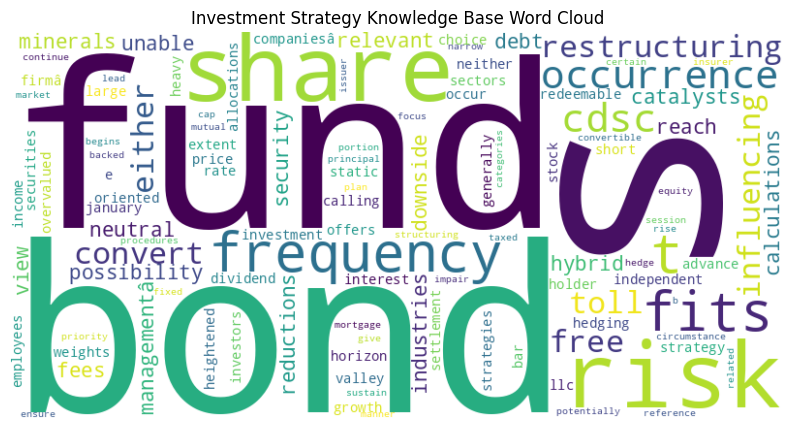

In [61]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# knowledge base
knowledge_base = ['frequency', 'funds', '529-t', 'fits', 'occurrence', 'cdsc', 'restructuring', 'influencing',
       'convert', 'either', 'toll-free', 'possibility', 'catalysts', 'unable', 'downside', 'debt',
       'neutral', 'risks', 'calculations', 'hybrid', 'relevant', 'view', 'reductions', 'industries',
       'managementâ\x80\x99s', 'security', 'fees', 'minerals', 'reach', 'independent', 'hedging',
       'offers', 'sectors', 'strategy', 'january', 'bonds', 'companiesâ\x80\x99', 'static', 'i.e.',
       'heightened', 'short', 'stock', 'redeemable', 'holder', 'extent', 'price', 'investment',
       'securities', 'overvalued', 'employees', 'interest', 'occur', 'bar', 'generally', 'neither',
       'dividend', 'valley', 'allocations', 'settlement', 'llc', 'large', 'horizon', 'rate',
       'investors', 'weights', 'income', 'strategies', 'calling', 'advance', 'bond', 'heavy',
       'choice', 'growth-oriented', 'firmâ\x80\x99s', 'potentially', 'sustain', 'market',
       'reference', 'issuer', 'cap', 'convertible', 'plan', 'priority', 'insurer', 'certain',
       'shares', 'session', 'give', 'focus', 'portion', 'procedures', 'narrow', 'fund', 'hedge',
       'share', 'risk', 'manner', 'circumstance', 'equity', 'categories', 'mutual', 'mortgage-backed',
       'b.', 'taxed', 'rise', 'impair', 'principal', 'related', 'continue', 'fixed', 'ensure',
       'begins', 'lead', 'structuring', 'their']

kb = knowledge_base

kb_str = ' '.join(kb)

# Word cloud
wc = WordCloud(width=800, height=400, background_color ='white').generate(kb_str)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Investment Strategy Knowledge Base Word Cloud')
plt.show()


## Step 4: Measure distance of each summary to each knowledge base.

The method is simply to count the number of words that are in the intersection of the knowledge base and the sentence. This scoring function is highly dependent on the number of neighbours chose to create the knowledge base.

In [56]:
def extract_sentence_match(summary, knowledge, num_sent):
    sentences = sent_tokenize(summary)
    sentence_scores = []
    for j, sentence in enumerate(sentences):
        set_tokens = set(tokenizer(sentence))

        # Find the number of common words between the knowledge base and the sentence
        inter_knwoledge = set_tokens.intersection(knowledge)

        sentence_scores.append(len(inter_knwoledge))

    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[len(sentences)-num_sent-1:]
    return ' '.join(top_sentences)

In [57]:
def extract_sentence_match_scores(summary, knowledge, num_sent):
    sentences = sent_tokenize(summary)
    sentence_scores = []
    for j, sentence in enumerate(sentences):
        set_tokens = set(tokenizer(sentence))

        # Find the number of common words between the knowledge base and the sentence
        inter_knwoledge = set_tokens.intersection(knowledge)

        sentence_scores.append(len(inter_knwoledge))

    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[len(sentences)-num_sent-1:]
    return sentence_scores

In [62]:
X_train['sentences_match']  = X_train.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)
X_train['sentences_match_scores']  = X_train.apply(lambda x : extract_sentence_match_scores(x['summary'], knowledge_base, num_sent=5), axis=1)

In [63]:
X_val['sentences_match'] = X_val.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)
X_val['sentences_match_scores'] = X_val.apply(lambda x : extract_sentence_match_scores(x['summary'], knowledge_base, num_sent=5), axis=1)


In [64]:
X_test['sentences_match'] = X_test.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)
X_test['sentences_match_scores'] = X_test.apply(lambda x : extract_sentence_match_scores(x['summary'], knowledge_base, num_sent=5), axis=1)


In [65]:
X_train['sentences_match_scores']

,sentences_match_scores
0,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ..."
1,"(0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"(0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, ..."
4,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, ..."
...,...
319,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ..."
320,"(0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
321,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
322,"(0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


## Step 5: Design a classification algorithm to predict the investment strategy of each fund.

### ML models

In [158]:
# Convert text to TF-IDF vectors
vectorizer_t = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_tfidf = vectorizer_t.fit_transform(X_train['summary'])
X_val_tfidf = vectorizer_t.transform(X_val['summary'])
X_test_tfidf = vectorizer_t.transform(X_test['summary'])

# Ensure y_train, y_val, y_test are 1D arrays
y_train_r = y_train.values.ravel()  # Converts DataFrame to 1D array
y_val_r = y_val.values.ravel()
y_test_r = y_test.values.ravel()

In [163]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Train Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_tfidf, y_train_r)

# Predict on validation data
y_val_pred = logreg.predict(X_val_tfidf)

# Evaluate the model
print("Logistic Regression Validation Results:")
print(classification_report(y_val_r, y_val_pred))
print(f"Validation Accuracy (Logistic Regression): {accuracy_score(y_val_r, y_val_pred):.4f}")

Logistic Regression Validation Results:
              precision    recall  f1-score   support

         0.0       0.89      0.81      0.85        21
         1.0       0.95      0.95      0.95        22
         2.0       0.95      0.98      0.96        54

    accuracy                           0.94        97
   macro avg       0.93      0.92      0.92        97
weighted avg       0.94      0.94      0.94        97

Validation Accuracy (Logistic Regression): 0.9381


In [162]:
# Predict on test data using Logistic Regression
y_test_pred_lr = logreg.predict(X_test_tfidf)

# Evaluate the Logistic Regression model
from sklearn.metrics import classification_report, accuracy_score

print("Logistic Regression Test Results:")
print(classification_report(y_test_r, y_test_pred_lr))
print(f"Test Accuracy (Logistic Regression): {accuracy_score(y_test_r, y_test_pred_lr):.4f}")


Logistic Regression Test Results:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         3
         1.0       0.86      1.00      0.92        12
         2.0       0.96      0.96      0.96        27
         3.0       0.00      0.00      0.00         2

    accuracy                           0.93        44
   macro avg       0.71      0.74      0.72        44
weighted avg       0.89      0.93      0.91        44

Test Accuracy (Logistic Regression): 0.9318


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [160]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Train an SVM model
svm_model = SVC(kernel='linear', random_state=42)  # Linear kernel for text data
svm_model.fit(X_train_tfidf, y_train_r)

# Predict on validation data
y_val_pred_svm = svm_model.predict(X_val_tfidf)

# Evaluate the model
print("SVM Validation Results:")
print(classification_report(y_val_r, y_val_pred_svm))
print(f"Validation Accuracy (SVM): {accuracy_score(y_val_r, y_val_pred_svm):.4f}")

# Predict on test data
y_test_pred_svm = svm_model.predict(X_test_tfidf)
print("SVM Test Results:")
print(classification_report(y_test_r, y_test_pred_svm))
print(f"Test Accuracy (SVM): {accuracy_score(y_test_r, y_test_pred_svm):.4f}")


SVM Validation Results:
              precision    recall  f1-score   support

         0.0       0.89      0.81      0.85        21
         1.0       0.91      0.95      0.93        22
         2.0       0.96      0.98      0.97        54

    accuracy                           0.94        97
   macro avg       0.92      0.92      0.92        97
weighted avg       0.94      0.94      0.94        97

Validation Accuracy (SVM): 0.9381
SVM Test Results:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         3
         1.0       0.86      1.00      0.92        12
         2.0       0.96      0.96      0.96        27
         3.0       0.00      0.00      0.00         2

    accuracy                           0.93        44
   macro avg       0.71      0.74      0.72        44
weighted avg       0.89      0.93      0.91        44

Test Accuracy (SVM): 0.9318


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [161]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can tune n_estimators
rf_model.fit(X_train_tfidf, y_train_r)

# Predict on validation data
y_val_pred_rf = rf_model.predict(X_val_tfidf)

# Evaluate the model
print("Random Forest Validation Results:")
print(classification_report(y_val_r, y_val_pred_rf))
print(f"Validation Accuracy (Random Forest): {accuracy_score(y_val_r, y_val_pred_rf):.4f}")

# Predict on test data
y_test_pred_rf = rf_model.predict(X_test_tfidf)
print("Random Forest Test Results:")
print(classification_report(y_test_r, y_test_pred_rf))
print(f"Test Accuracy (Random Forest): {accuracy_score(y_test_r, y_test_pred_rf):.4f}")


Random Forest Validation Results:
              precision    recall  f1-score   support

         0.0       0.95      0.86      0.90        21
         1.0       0.96      1.00      0.98        22
         2.0       0.96      0.98      0.97        54

    accuracy                           0.96        97
   macro avg       0.96      0.95      0.95        97
weighted avg       0.96      0.96      0.96        97

Validation Accuracy (Random Forest): 0.9588
Random Forest Test Results:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         3
         1.0       0.86      1.00      0.92        12
         2.0       0.96      0.96      0.96        27
         3.0       0.00      0.00      0.00         2

    accuracy                           0.93        44
   macro avg       0.71      0.74      0.72        44
weighted avg       0.89      0.93      0.91        44

Test Accuracy (Random Forest): 0.9318


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Logistic Regression, SVM, and Random Forest all achieved the same test accuracy of 93.18%, with Logistic Regression and SVM showing consistent validation accuracy of 93.81% and Random Forest slightly higher at 95.88%, suggesting potential overfitting. However, analysis of the classification metrics reveals that certain classes have no predicted samples, likely due to class imbalance or model limitations in distinguishing between overlapping features. This limitation in traditional machine learning models leads to identical test results and highlights the need to explore deep learning (DL) approaches, which can better capture complex patterns in the data and handle imbalances effectively through techniques like embeddings or class-weight adjustments.

### Data Preparation for DL

First, we set the hyper parameters of the pre-processing phase.

In [69]:
Xv = X_train['sentences_match'].values

Xv = [' '.join(tokenizer(txt)) for txt in Xv]
Xv[0][:100]

'allianz funds table contents allianzgi mid-cap fund continued management fund investment adviser adm'

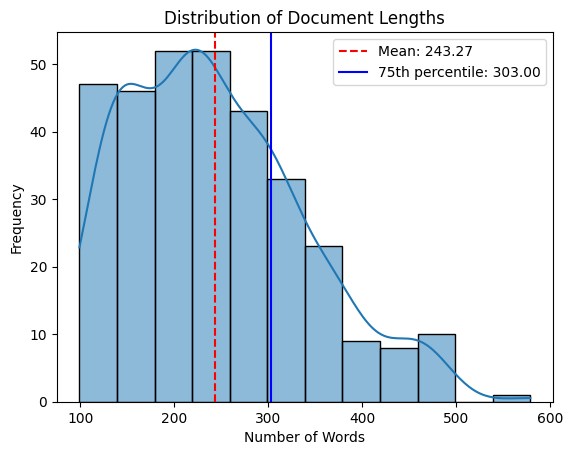

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

sizes = [len(word_tokenize(txt)) for txt in Xv]

median_size = np.median(sizes)
mean_size = np.mean(sizes)
percentile_75 = np.percentile(sizes, 75)

# Plot and find an approximate number for parameter 'maxlen'
#sns.distplot(sizes, kde=False, rug=True)
#sns.histplot(sizes, kde=True,color='#68C6E3')
sns.histplot(sizes, kde=True)
plt.axvline(mean_size, color='r', linestyle='--', label=f'Mean: {mean_size:.2f}')
plt.axvline(percentile_75, color='b', linestyle='-', label=f'75th percentile: {percentile_75:.2f}')
plt.legend()
plt.title('Distribution of Document Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [74]:
num_words = 2500 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 300 # Number of word considered for each document. we cut or lengthen the texts to have texts of 200 words.
word_dimension = 50 # dimension of our word vectors.

Then, we load the standford glove.6B.50d pretrained word2vec.

In [75]:
word2vec_g = load_word2vec(glove_word2vec)

In [76]:
# produce train_X, valid_X and test_X
train_X = X_train['sentences_match'].values
# Clean the texts
train_X = [' '.join(tokenizer(txt)) for txt in train_X]

In [77]:
val_X = X_val['sentences_match'].values
val_X = [' '.join(tokenizer(txt)) for txt in val_X]

In [78]:
test_X = X_test['sentences_match'].values
test_X = [' '.join(tokenizer(txt)) for txt in test_X]

We start the feature creation by assigning a unique index to each word in the vocabulary of the corpus and transform the texts to a list of word index.

In [79]:
keras_tokenizer = Tokenizer(num_words=num_words)
keras_tokenizer.fit_on_texts(train_X)
word_index = keras_tokenizer.word_index

sequences_train = keras_tokenizer.texts_to_sequences(train_X)
sequences_val = keras_tokenizer.texts_to_sequences(val_X)
sequences_test = keras_tokenizer.texts_to_sequences(test_X)

Then we use the pad_sequence function provided by keras to truncate or lengthen (by adding zeros) each text so they all have the same length : 300

In [80]:
# truncate or lenthen each text so they have the same length.
feature_train = pad_sequences(sequences_train, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_val = pad_sequences(sequences_val, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test = pad_sequences(sequences_test, maxlen=maxlen, dtype=float, padding='post', truncating='post')

In [81]:
embedding_matrix = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    embedding_vector = word2vec_g.get(word)
    #embedding_vector = word2vec.get(word)   # or use our own word2vec
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.00660002,  0.55454999,  0.37957001, ...,  0.69673002,
         0.10138   ,  0.81498998],
       [ 0.79548001,  0.4639    ,  0.49250999, ...,  0.87593001,
         0.69827998,  0.97692001],
       ...,
       [ 0.44435   , -1.14760005, -0.028468  , ...,  1.60469997,
        -0.23614   ,  1.23389995],
       [-0.60393   ,  0.019324  ,  0.044003  , ...,  0.75783998,
        -0.06678   ,  0.47198999],
       [-0.95849001,  0.17321   ,  0.25165001, ...,  0.23081   ,
        -0.36469001,  1.54560006]])

Start to build our models!

In [82]:
# process data
from tensorflow.keras.utils import to_categorical
feature_train = np.asarray(feature_train).astype('float32')
feature_val = np.asarray(feature_val).astype('float32')
feature_test = np.asarray(feature_test).astype('float32')
y_train_categorical = to_categorical(y_train, num_classes = 4)
y_test_categorical = to_categorical(y_test, num_classes = 4)
y_val_categorical = to_categorical(y_val, num_classes = 4)
y_train_categorical

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

### CNN Model

In [85]:
def create_CNN_model(filters,kernel_size,dropout,pool_size):
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], trainable=False))

    CNN.add(Convolution1D(filters, kernel_size, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size))

    CNN.add(Convolution1D(filters, kernel_size, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size))

    CNN.add(Flatten())
    CNN.add(Dense(units = 128 , activation = 'relu'))
    CNN.add(Dropout(dropout))
    CNN.add(Dense(units = 4, activation = 'softmax'))

    CNN.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics = ['accuracy'])
    return CNN

In [84]:
CNN_model = create_CNN_model(filters=32,kernel_size=5,dropout=0.5,pool_size=5)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
CNN_history = CNN_model.fit(feature_train, y_train_categorical, epochs=20, batch_size=32, validation_data=(feature_val, y_val_categorical))

Epoch 1/20
11/11 [==============================] - 2s 53ms/step - loss: 1.4066 - accuracy: 0.3981 - val_loss: 1.0004 - val_accuracy: 0.6082
Epoch 2/20
11/11 [==============================] - 0s 24ms/step - loss: 1.0429 - accuracy: 0.4877 - val_loss: 0.9080 - val_accuracy: 0.6082
Epoch 3/20
11/11 [==============================] - 0s 20ms/step - loss: 0.9701 - accuracy: 0.5432 - val_loss: 0.8669 - val_accuracy: 0.6495
Epoch 4/20
11/11 [==============================] - 0s 21ms/step - loss: 0.8932 - accuracy: 0.5617 - val_loss: 0.7675 - val_accuracy: 0.7320
Epoch 5/20
11/11 [==============================] - 0s 23ms/step - loss: 0.8089 - accuracy: 0.6975 - val_loss: 0.7035 - val_accuracy: 0.7526
Epoch 6/20
11/11 [==============================] - 0s 20ms/step - loss: 0.7048 - accuracy: 0.7222 - val_loss: 0.6372 - val_accuracy: 0.7732
Epoch 7/20
11/11 [==============================] - 0s 19ms/step - loss: 0.6764 - accuracy: 0.7222 - val_loss: 0.6476 - val_accuracy: 0.7216
Epoch 8/20
11

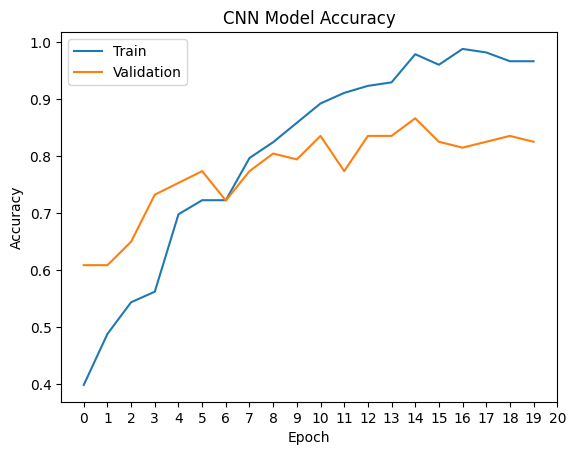

In [ ]:
# Plot training & validation accuracy
plt.plot(CNN_history.history['accuracy'])
plt.plot(CNN_history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks(range(21))
plt.show()

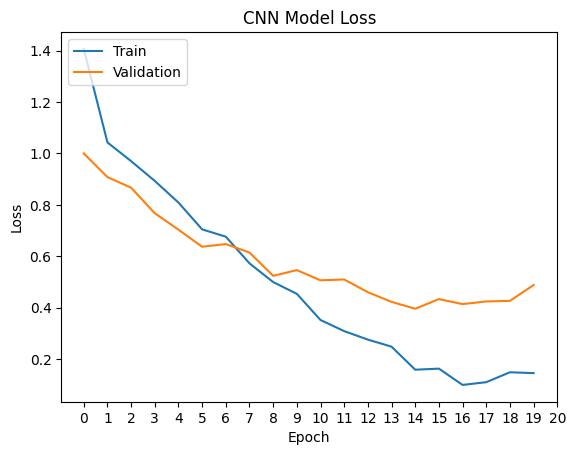

In [ ]:
# Plot training & validation loss values
plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks(range(21))
plt.show()

In [ ]:
#  cnn model predict
y_val_pred_CNN = CNN_model.predict(feature_val)
# Transform categorical variables back to 0, 1, 2, 3...
y_val_pred_CNN_ori = np.argmax(y_val_pred_CNN, axis=1)
y_val = np.asarray(y_val).astype('int')

4/4 [==============================] - 0s 6ms/step


In [ ]:
from sklearn.metrics import classification_report
print("The confusion matrix of CNN model for validation data\n")
print(classification_report(y_val, y_val_pred_CNN_ori))

The confusion matrix of CNN model for validation data

              precision    recall  f1-score   support

           0       1.00      0.67      0.80        21
           1       0.82      0.64      0.72        22
           2       0.79      0.96      0.87        54

    accuracy                           0.82        97
   macro avg       0.87      0.76      0.79        97
weighted avg       0.84      0.82      0.82        97



In [ ]:
CNN_model.summary()

NameError: name 'CNN_model' is not defined

### RNN Model

In [ ]:
def create_RNN_model():
    RNN = Sequential()
    RNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))

    RNN.add(Bidirectional(LSTM(word_dimension)))
    RNN.add(Dense(word_dimension, activation='relu'))
    RNN.add(Dense(4, activation='softmax'))
    RNN.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    return RNN

In [ ]:
RNN_model = create_RNN_model()

In [ ]:
RNN_history = RNN_model.fit(feature_train, y_train_categorical, epochs=20, batch_size=32, validation_data=(feature_val, y_val_categorical))

Epoch 1/20
11/11 [==============================] - 8s 378ms/step - loss: 1.2292 - accuracy: 0.4846 - val_loss: 1.0464 - val_accuracy: 0.5567
Epoch 2/20
11/11 [==============================] - 2s 165ms/step - loss: 1.0433 - accuracy: 0.5185 - val_loss: 0.9760 - val_accuracy: 0.5773
Epoch 3/20
11/11 [==============================] - 2s 147ms/step - loss: 0.9538 - accuracy: 0.5802 - val_loss: 0.8626 - val_accuracy: 0.6598
Epoch 4/20
11/11 [==============================] - 2s 149ms/step - loss: 0.8583 - accuracy: 0.6173 - val_loss: 0.8042 - val_accuracy: 0.6907
Epoch 5/20
11/11 [==============================] - 2s 163ms/step - loss: 0.7622 - accuracy: 0.7006 - val_loss: 0.6450 - val_accuracy: 0.7113
Epoch 6/20
11/11 [==============================] - 2s 150ms/step - loss: 0.6954 - accuracy: 0.7037 - val_loss: 0.6399 - val_accuracy: 0.7010
Epoch 7/20
11/11 [==============================] - 2s 147ms/step - loss: 0.6276 - accuracy: 0.7469 - val_loss: 0.7106 - val_accuracy: 0.6392
Epoch 

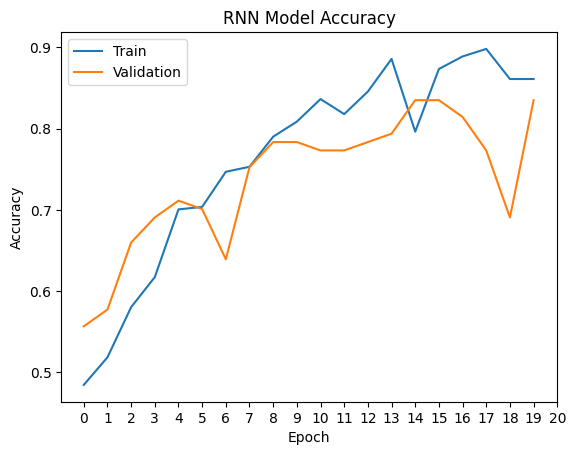

In [ ]:
# Plot training & validation accuracy values
plt.plot(RNN_history.history['accuracy'])
plt.plot(RNN_history.history['val_accuracy'])
plt.title('RNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks(range(21))
plt.show()

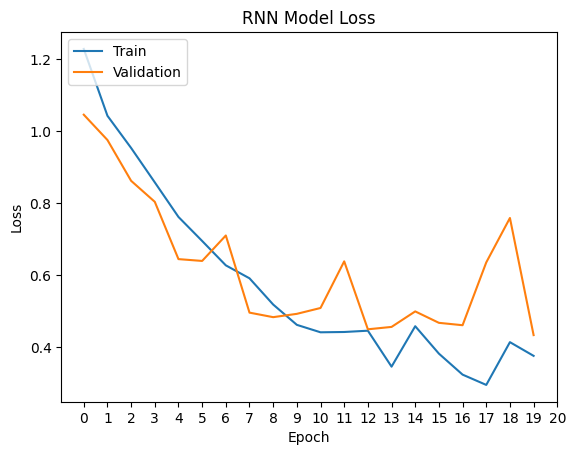

In [ ]:
# Plot training & validation loss values
plt.plot(RNN_history.history['loss'])
plt.plot(RNN_history.history['val_loss'])
plt.title('RNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks(range(21))
plt.show()

In [ ]:
#  cnn model predict
y_val_pred_RNN = RNN_model.predict(feature_val)
# Transform categorical variables back to 0, 1, 2, 3...
y_val_pred_RNN_ori = np.argmax(y_val_pred_RNN, axis=1)
#y_val = np.asarray(y_val).astype('int')

4/4 [==============================] - 1s 34ms/step


In [ ]:
from sklearn.metrics import classification_report
print("The confusion matrix of RNN model for valiation data\n")
print(classification_report(y_val, y_val_pred_RNN_ori))

The confusion matrix of RNN model for valiation data

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        21
           1       0.80      0.55      0.65        22
           2       0.85      0.96      0.90        54

    accuracy                           0.84        97
   macro avg       0.82      0.77      0.79        97
weighted avg       0.83      0.84      0.83        97



## Step 6: Use validation data to tune parameters of classification algorithms.

Given that CNN has the higher AUC score and val_accuracies, we choose CNN model as my final classifier, then we will use cross validation to tune the hyper parameters!

### Tune Process

use ParameterGrid to tune the hyper parameters

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
import numpy as np
# It takes at least 6 hours if we want to tune all six hyper parameters!!!!!!OMG
# That is crazy, so maybe we can only focus on these four parameters
# Define the hyperparameters we want to tune
param_grid = {
    'filters': [32, 64, 128],
    'kernel_size': [3, 5, 7],
    'dropout': [0.2, 0.5, 0.8],
    #'pool_size': [3, 5, 7],
    #'epochs': [10, 20, 50],
    'batch_size': [16, 32, 64]
}

# Define the number of folds for cross-validation
num_folds = 5

# Create a KFold object to split the data
kf = KFold(n_splits=num_folds, shuffle=True)

# Create empty lists to store the validation scores for each combination of hyperparameters
val_scores = []

# Loop over all combinations of hyperparameters
for params in ParameterGrid(param_grid):
    filters = params['filters']
    kernel_size = params['kernel_size']
    dropout = params['dropout']
    #pool_size = params['pool_size']
    #epochs = params['epochs']
    batch_size = params['batch_size']
    # Create a new model with the current hyperparameters
    model = create_CNN_model(filters, kernel_size, dropout,pool_size=5)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

    # Loop over all folds
    fold_scores = []
    for train_idx, val_idx in kf.split(feature_train):

        # Get the training and validation data for this fold
        X_train, y_train = feature_train[train_idx], y_train_categorical[train_idx]
        X_val, y_val = feature_train[val_idx], y_train_categorical[val_idx]

        # Train the model on the training data for this fold
        history = model.fit(X_train, y_train, epochs= 20, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0)

        # Get the validation score for this fold and append it to the list of fold scores
        fold_score = history.history['val_accuracy'][-1]
        fold_scores.append(fold_score)

    # Calculate the average validation score for this combination of hyperparameters and append it to the list of validation scores
    avg_val_score = np.mean(fold_scores)
    val_scores.append({'params': params, 'score': avg_val_score})

# Print the validation scores for each combination of hyperparameters
for val_score in val_scores:
    print(val_score)


{'params': {'batch_size': 16, 'dropout': 0.2, 'filters': 32, 'kernel_size': 3}, 'score': 0.9569230794906616}
{'params': {'batch_size': 16, 'dropout': 0.2, 'filters': 32, 'kernel_size': 5}, 'score': 0.9292307734489441}
{'params': {'batch_size': 16, 'dropout': 0.2, 'filters': 32, 'kernel_size': 7}, 'score': 0.9352403879165649}
{'params': {'batch_size': 16, 'dropout': 0.2, 'filters': 64, 'kernel_size': 3}, 'score': 0.9384615421295166}
{'params': {'batch_size': 16, 'dropout': 0.2, 'filters': 64, 'kernel_size': 5}, 'score': 0.9384615421295166}
{'params': {'batch_size': 16, 'dropout': 0.2, 'filters': 64, 'kernel_size': 7}, 'score': 0.9353846192359925}
{'params': {'batch_size': 16, 'dropout': 0.2, 'filters': 128, 'kernel_size': 3}, 'score': 0.9415384650230407}
{'params': {'batch_size': 16, 'dropout': 0.2, 'filters': 128, 'kernel_size': 5}, 'score': 0.9630769252777099}
{'params': {'batch_size': 16, 'dropout': 0.2, 'filters': 128, 'kernel_size': 7}, 'score': 0.9476923108100891}
{'params': {'bat

In [ ]:
# Select the hyperparameters with the highest validation score and train a final model
best_params = max(val_scores, key=lambda x: x['score'])['params']
print('The best hyper parameters are',best_params)

The best hyper parameters are {'batch_size': 16, 'dropout': 0.5, 'filters': 32, 'kernel_size': 3}


In [ ]:
#t_filters = best_params['filters']
#t_kernel_size = best_params['kernel_size']
#t_dropout = best_params['dropout']
#t_pool_size = best_params['pool_size']
#t_epochs = best_params['epochs']
#t_batch_size = best_params['batch_size']

In [ ]:
# Rerun tune process is extremely time-consuming!!! so I write down the numbers instead
t_filters = 32
t_kernel_size = 3
t_dropout = 0.5
#t_pool_size = best_params['pool_size']
#t_epochs = best_params['epochs']
t_batch_size = 16

### Tuned Model

In [ ]:
# truncate or lenthen each text so they have the same length.
feature_train = pad_sequences(sequences_train, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_val = pad_sequences(sequences_val, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test = pad_sequences(sequences_test, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_train = np.asarray(feature_train).astype('float32')
feature_val = np.asarray(feature_val).astype('float32')
feature_test = np.asarray(feature_test).astype('float32')

In [ ]:
tuned_CNN_model = create_CNN_model(t_filters,t_kernel_size,t_dropout,pool_size=5)
tuned_CNN_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
feature_train[322] =feature_train[322]*0.01
feature_train[323] =feature_train[323]*0.01
feature_test[42]=feature_train[42]*0.01
feature_test[43] =feature_test[43]*0.01
tuned_CNN_history = tuned_CNN_model.fit(feature_train, y_train_categorical, epochs=40, batch_size=t_batch_size, validation_data=(feature_val, y_val_categorical))

Epoch 1/40
21/21 [==============================] - 4s 52ms/step - loss: 1.1682 - accuracy: 0.4259 - val_loss: 0.9711 - val_accuracy: 0.5670
Epoch 2/40
21/21 [==============================] - 0s 20ms/step - loss: 1.0162 - accuracy: 0.5617 - val_loss: 0.8740 - val_accuracy: 0.6701
Epoch 3/40
21/21 [==============================] - 0s 19ms/step - loss: 0.8621 - accuracy: 0.6543 - val_loss: 0.7810 - val_accuracy: 0.7423
Epoch 4/40
21/21 [==============================] - 0s 22ms/step - loss: 0.7707 - accuracy: 0.6914 - val_loss: 0.7765 - val_accuracy: 0.7113
Epoch 5/40
21/21 [==============================] - 0s 18ms/step - loss: 0.6550 - accuracy: 0.7778 - val_loss: 0.5684 - val_accuracy: 0.7938
Epoch 6/40
21/21 [==============================] - 0s 18ms/step - loss: 0.5371 - accuracy: 0.8025 - val_loss: 0.5267 - val_accuracy: 0.7938
Epoch 7/40
21/21 [==============================] - 0s 22ms/step - loss: 0.4128 - accuracy: 0.8735 - val_loss: 0.5059 - val_accuracy: 0.8351
Epoch 8/40
21

In [ ]:
#  cnn model predict
y_test_pred_tuned_CNN = tuned_CNN_model.predict(feature_test)
# Transform categorical variables back to 0, 1, 2, 3
y_test_pred_tuned_CNN_ori = np.argmax(y_test_pred_tuned_CNN, axis=1)
print(y_test_pred_tuned_CNN_ori)
from sklearn.metrics import classification_report
print("The confusion matrix for test data based on all types of funds\n")
print(classification_report(y_test, y_test_pred_tuned_CNN_ori))

2/2 [==============================] - 0s 10ms/step
[0 1 1 2 2 2 2 2 1 1 2 2 1 2 2 2 2 0 1 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 1 2
 1 0 2 2 2 3 2]
The confusion matrix for test data based on all types of funds

              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67         3
         1.0       0.80      0.67      0.73        12
         2.0       0.83      0.93      0.88        27
         3.0       1.00      0.50      0.67         2

    accuracy                           0.82        44
   macro avg       0.83      0.69      0.73        44
weighted avg       0.82      0.82      0.81        44



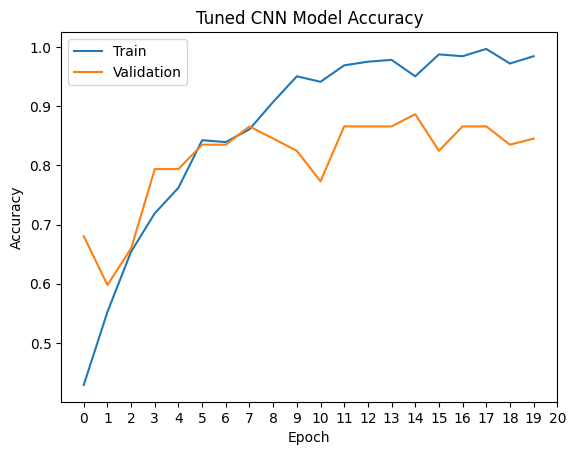

In [ ]:
# Plot training & validation accuracy
plt.plot(tuned_CNN_history.history['accuracy'])
plt.plot(tuned_CNN_history.history['val_accuracy'])
plt.title('Tuned CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks(range(21))
plt.show()

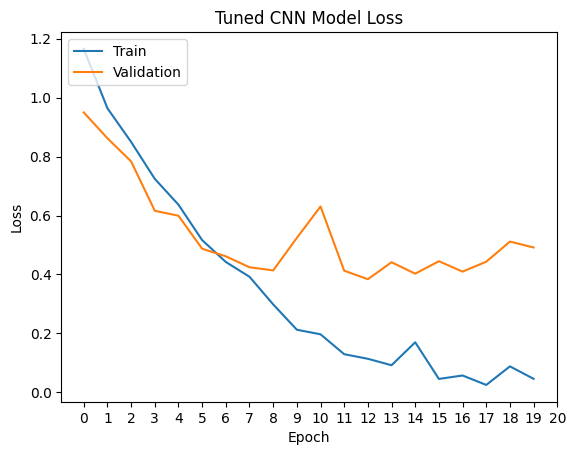

In [ ]:
# Plot training & validation loss values
plt.plot(tuned_CNN_history.history['loss'])
plt.plot(tuned_CNN_history.history['val_loss'])
plt.title('Tuned CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks(range(21))
plt.show()

In [ ]:
#  cnn model predict
y_val_pred_tuned_CNN = tuned_CNN_model.predict(feature_val)
y_val_pred_tuned_CNN_ori = np.argmax(y_val_pred_tuned_CNN, axis=1)

4/4 [==============================] - 0s 13ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_pred_tuned_CNN_ori))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        21
           1       0.73      0.86      0.79        22
           2       0.92      0.85      0.88        54

    accuracy                           0.85        97
   macro avg       0.82      0.84      0.83        97
weighted avg       0.85      0.85      0.85        97



## Step 7: Apply classification algorithm to predict the investment strategy of each fund in the test data.

In [ ]:
#  cnn model predict
y_test_pred_tuned_CNN = tuned_CNN_model.predict(feature_test)
# Transform categorical variables back to 0, 1, 2, 3
y_test_pred_tuned_CNN_ori = np.argmax(y_test_pred_tuned_CNN, axis=1)
print(y_test_pred_tuned_CNN_ori)

2/2 [==============================] - 0s 9ms/step
[0 1 1 2 2 2 2 2 1 1 0 2 1 2 2 2 2 0 1 2 2 1 1 2 2 2 1 2 2 2 2 2 2 1 2 1 1
 1 1 2 0 2 2 2]


In [ ]:
from sklearn.metrics import classification_report
print("The confusion matrix for test data based on all types of funds\n")
print(classification_report(y_test, y_test_pred_tuned_CNN_ori))

The confusion matrix for test data based on all types of funds

              precision    recall  f1-score   support

         0.0       0.50      0.67      0.57         3
         1.0       0.71      0.83      0.77        12
         2.0       0.88      0.85      0.87        27
         3.0       0.00      0.00      0.00         2

    accuracy                           0.80        44
   macro avg       0.52      0.59      0.55        44
weighted avg       0.77      0.80      0.78        44



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Major Process

exclude the L/S funds, only focus on the first three types of funds

### Major Data


In [ ]:
# Split the feature and the target
major_X = df_merge[df_merge.columns.drop('Investment_Strategy')]
major_y = df_merge['Investment_Strategy']
major_y.value_counts()

2.0    247
1.0    130
0.0     84
Name: Investment_Strategy, dtype: int64

In [ ]:
# Split the data into training and testing sets
major_X_train, major_X_val, major_y_train, major_y_val = train_test_split(major_X, major_y, test_size=0.3, random_state=42)
# Split the training data into training and validation sets
major_X_val, major_X_test, major_y_val, major_y_test = train_test_split(major_X_val, major_y_val, test_size=0.3, random_state=42)
# Print the shapes of the major funds data sets
print(f"Training set shape: {major_X_train.shape},{major_y_train.shape}")
print(f"Validation set shape: {major_X_val.shape},{major_y_val.shape}")
print(f"Testing set shape: {major_X_test.shape},{major_y_test.shape}")

Training set shape: (322, 7),(322,)
Validation set shape: (97, 7),(97,)
Testing set shape: (42, 7),(42,)


In [ ]:
exclude_knowledge_base = knowledge_base_bf | knowledge_base_fi | knowledge_base_eq
print(exclude_knowledge_base)

{'stock', 'index', 'driven', 'depth', 'complementary', 'nav', 'debt', 'switzerland', 'profitability', 'yield', 'hypothetically', 'benefits', 'r', 't.', 'convert', 'price-to-book', 'protecting', 'day', 'bond', 'prompt', 'tax-efficient', 'technical', 'every', 'correct', 'holder', 'least', 'bonds', 'fixed', 'represents', 'maximize', 'price', 'etfs', 'security', 'italy', 'principal', 'issuer', 'affected', 'loss', 'trust', 'requirement', 'month', 'governmental', 'toward', 'certain', 'assets', 'movements', 'rate', 'fund', 'equity', 'implement', 'stocks', 'morningstar', 'establish', 'pays', 'magnitude', 'dividend', 'discretionary', 'frontier', 'long', 'interest', 'channels', 'growth', 'tips', 'hybrid', 'blend', 'opened', 'share', 'â\x80\x9clongâ\x80\x9d', 'responding', 'emphasizes', 'e', 'move', 'short-', 'funds', 'satisfy', 'finance', 'considering', 'â\x80\x9cexample', 'income', 'shares', 'reimbursement2', 'fitch', 'tools', 'â\x80\x9cprivate', 'enable', 'convertible', 'holds', 'securities', 

In [ ]:
def extract_sentence_match(summary, knowledge, num_sent):
    sentences = sent_tokenize(summary)
    sentence_scores = []
    for j, sentence in enumerate(sentences):
        set_tokens = set(tokenizer(sentence))

        # Find the number of common words between the knowledge base and the sentence
        inter_knwoledge = set_tokens.intersection(knowledge)

        sentence_scores.append(len(inter_knwoledge))

    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[len(sentences)-num_sent-1:]
    return ' '.join(top_sentences)

In [ ]:
major_X_train['sentences_match']  = major_X_train.apply(lambda x : extract_sentence_match(x['summary'], exclude_knowledge_base, num_sent=5), axis=1)
major_X_val['sentences_match']  = major_X_val.apply(lambda x : extract_sentence_match(x['summary'], exclude_knowledge_base, num_sent=5), axis=1)
major_X_test['sentences_match']  = major_X_val.apply(lambda x : extract_sentence_match(x['summary'], exclude_knowledge_base, num_sent=5), axis=1)

In [ ]:
# clean and tokenize the text
def tokenizer(txt):
    """tokenizer

    Args:
        txt (str): text to be tokenized

    Returns:
        filtered_sentence (list): list of tokenized string.
    """
    txt = txt.replace('\n', ' ').replace('\t', ' ').lower()
    word_tokens = word_tokenize(txt)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = [w for w in filtered_sentence if re.sub("[^A-Za-z ]+",'',w) != '']
    return filtered_sentence

In [ ]:
# produce train_X, valid_X and test_X
train_X_major = major_X_train['sentences_match'].values
# Clean the texts
train_X_major = [' '.join(tokenizer(txt)) for txt in train_X_major]

In [ ]:
val_X_major = major_X_val['sentences_match'].values
val_X_major = [' '.join(tokenizer(txt)) for txt in val_X_major]

In [ ]:
test_X_major = test_X[:-2]

In [ ]:
num_words = 2500 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 200 # Number of word considered for each document. we cut or lengthen the texts to have texts of 200 words.
word_dimension = 50 # dimension of our word vectors.

In [ ]:
keras_tokenizer = Tokenizer(num_words=num_words)
keras_tokenizer.fit_on_texts(train_X_major)
word_index_major = keras_tokenizer.word_index

sequences_train_major = keras_tokenizer.texts_to_sequences(train_X_major)
sequences_val_major = keras_tokenizer.texts_to_sequences(val_X_major)
sequences_test_major = keras_tokenizer.texts_to_sequences(test_X_major)

In [ ]:
# truncate or lenthen each text so they have the same length.
feature_train_major = pad_sequences(sequences_train_major, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_val_major = pad_sequences(sequences_val_major, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test_major = pad_sequences(sequences_test_major, maxlen=maxlen, dtype=float, padding='post', truncating='post')

In [ ]:
print ('length of the first sequence : '+str(len(sequences_train_major[0])) )
print ('length of the paded first sequence : '+str(len(feature_train_major[0])) )

length of the first sequence : 346
length of the paded first sequence : 200


In [ ]:
embedding_matrix_major = np.zeros((len(word_index_major) + 1, word_dimension))
for word, i in word_index_major.items():
    embedding_vector_major = word2vec_g.get(word)
    #embedding_vector = word2vec.get(word)   # or use our own word2vec
    if embedding_vector_major is not None:
        embedding_matrix_major[i] = embedding_vector_major

embedding_matrix_major

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.00660002,  0.55454999,  0.37957001, ...,  0.69673002,
         0.10138   ,  0.81498998],
       [-0.44984999,  0.97530001,  0.060652  , ..., -0.65416002,
         0.26320001,  0.61969   ],
       ...,
       [-0.54519999,  0.58174998,  0.40830001, ..., -0.98075998,
         0.92395002, -0.40632999],
       [ 0.77907997,  0.85637999,  0.40487999, ..., -0.44846001,
         0.10015   ,  1.90550005],
       [-0.45113   ,  0.84592003, -0.027738  , ..., -0.66645002,
         1.30630004,  0.26881999]])

In [ ]:
# process data
from tensorflow.keras.utils import to_categorical
y_train_categorical_major = to_categorical(major_y_train, num_classes = 3)
y_test_categorical_major = to_categorical(major_y_test, num_classes = 3)
y_val_categorical_major = to_categorical(major_y_val, num_classes = 3)
y_val_categorical_major.shape

(97, 3)

### Major Model

In [ ]:
def create_major_CNN_model(filters,kernel_size,dropout,pool_size):
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index_major) + 1, word_dimension, weights=[embedding_matrix_major], input_length = maxlen, trainable=False))

    CNN.add(Convolution1D(filters, kernel_size, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size))

    CNN.add(Convolution1D(filters, kernel_size, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size))

    CNN.add(Flatten())
    CNN.add(Dense(units = 128 , activation = 'relu'))
    CNN.add(Dropout(dropout))
    CNN.add(Dense(units = 3, activation = 'softmax'))

    CNN.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics = ['accuracy'])
    return CNN

In [ ]:
major_CNN_model = create_major_CNN_model(filters=32,kernel_size=5,dropout=0.5,pool_size=5)

In [ ]:
major_CNN_history = major_CNN_model.fit(feature_train_major, y_train_categorical_major, epochs=20, batch_size=32, validation_data=(feature_val_major, y_val_categorical_major))

Epoch 1/20
11/11 [==============================] - 2s 52ms/step - loss: 1.3961 - accuracy: 0.4068 - val_loss: 0.9612 - val_accuracy: 0.5155
Epoch 2/20
11/11 [==============================] - 0s 30ms/step - loss: 0.9555 - accuracy: 0.5311 - val_loss: 0.8938 - val_accuracy: 0.5876
Epoch 3/20
11/11 [==============================] - 0s 23ms/step - loss: 0.8774 - accuracy: 0.6149 - val_loss: 0.8257 - val_accuracy: 0.5876
Epoch 4/20
11/11 [==============================] - 0s 30ms/step - loss: 0.8456 - accuracy: 0.6118 - val_loss: 0.8102 - val_accuracy: 0.7216
Epoch 5/20
11/11 [==============================] - 0s 25ms/step - loss: 0.7583 - accuracy: 0.6988 - val_loss: 0.6926 - val_accuracy: 0.7423
Epoch 6/20
11/11 [==============================] - 0s 38ms/step - loss: 0.6414 - accuracy: 0.7422 - val_loss: 0.7203 - val_accuracy: 0.7113
Epoch 7/20
11/11 [==============================] - 0s 45ms/step - loss: 0.5958 - accuracy: 0.7671 - val_loss: 0.5724 - val_accuracy: 0.7732
Epoch 8/20
11

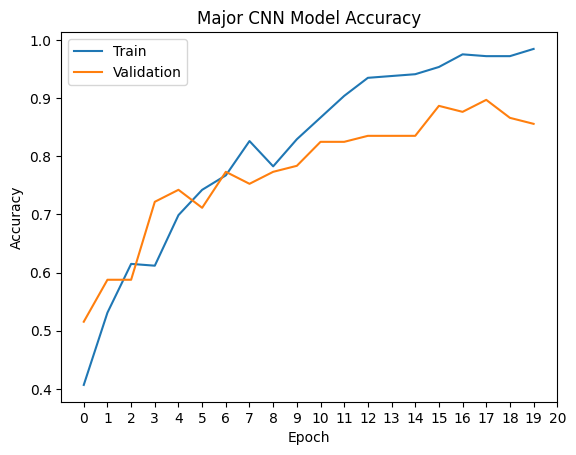

In [ ]:
# Plot training & validation accuracy
plt.plot(major_CNN_history.history['accuracy'])
plt.plot(major_CNN_history.history['val_accuracy'])
plt.title('Major CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks(range(21))
plt.show()

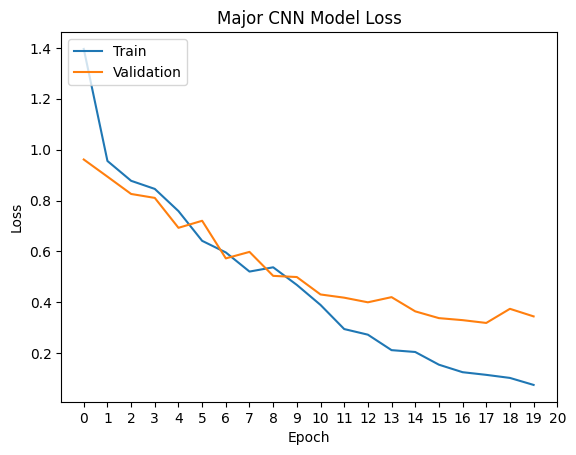

In [ ]:
# Plot training & validation loss values
plt.plot(major_CNN_history.history['loss'])
plt.plot(major_CNN_history.history['val_loss'])
plt.title('Major CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks(range(21))
plt.show()

In [ ]:
#  cnn model predict
y_test_pred_major_CNN = major_CNN_model.predict(feature_test_major)

# Transform categorical variables back to 0, 1, 2
y_test_pred_major_CNN_ori = np.argmax(y_test_pred_major_CNN, axis=1)

2/2 [==============================] - 0s 9ms/step


In [ ]:
from sklearn.metrics import classification_report
print("The confusion matrix of CNN model for test data based on major funds\n")
print(classification_report(major_y_test, y_test_pred_major_CNN_ori))

The confusion matrix of CNN model for test data based on major funds

              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80         3
         1.0       0.69      0.92      0.79        12
         2.0       0.96      0.85      0.90        27

    accuracy                           0.86        42
   macro avg       0.88      0.81      0.83        42
weighted avg       0.88      0.86      0.86        42

